In [10]:
# Imports
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

import locale
from locale import atoi

In [11]:
# Read in data 
property_inventory = pd.read_csv("./datasets/annual_property_inventory_2017.csv")
list(property_inventory)

['Jur Dept',
 'Jurisdictional Dept',
 'PMA NUM',
 'PMA Name',
 'PMA Location Address',
 ' PMA Land SqFt ',
 'PMA Classification',
 'PMA Current Use',
 'PMA Future Use If Any',
 'City Ownership',
 'Category',
 'Comment']

In [18]:
# Cleaning up

# Converting from Strings to numbers
# Removing commas 
# Converting dashes to zeroes
locale.setlocale(locale.LC_NUMERIC, '')

def toNumber(n):
    try:
        return atoi(n)
    except:
        # print("Didn't work with " + n)
        return 0
    
property_inventory[' PMA Land SqFt '] = property_inventory[' PMA Land SqFt '].map(toNumber)

In [19]:
# Calculate total land owned by Seattle City. 
total_land = sum(property_inventory[' PMA Land SqFt '])
print("Total land:   " + str(total_land) + " sq. ft")

utilized_land = sum(property_inventory.loc[property_inventory['PMA Classification'] == "Fully Utilized"][' PMA Land SqFt '])
print("Fully utilized land:" + str(utilized_land) + " sq. ft")
print("Fully utilized %age:" + str(utilized_land / total_land * 100) + "%")
print("Land that is not fully utilized: " + str(total_land - utilized_land) + " sq. ft")

distribution = property_inventory.groupby(['PMA Classification']).sum()[' PMA Land SqFt ']
distribution

Total land:   5559871984 sq. ft
Fully utilized land:5542045626 sq. ft
Fully utilized %age:99.6793746681%
Land that is not fully utilized: 17826358 sq. ft


PMA Classification
Excess               5165098
Fully Utilized    5542045626
Interim Use          1087294
Surplus             11307777
Underutilized         221850
Unknown                41644
Unused                  2695
Name:  PMA Land SqFt , dtype: int64

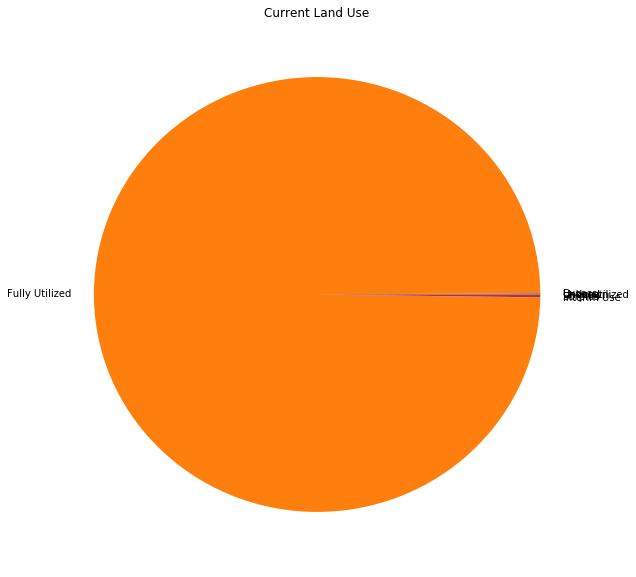

In [20]:
# Current land use distribution
series = pd.Series(distribution, name=' ')
series.plot.pie(figsize=(10, 10))
plt.title("Current Land Use")
plt.show()

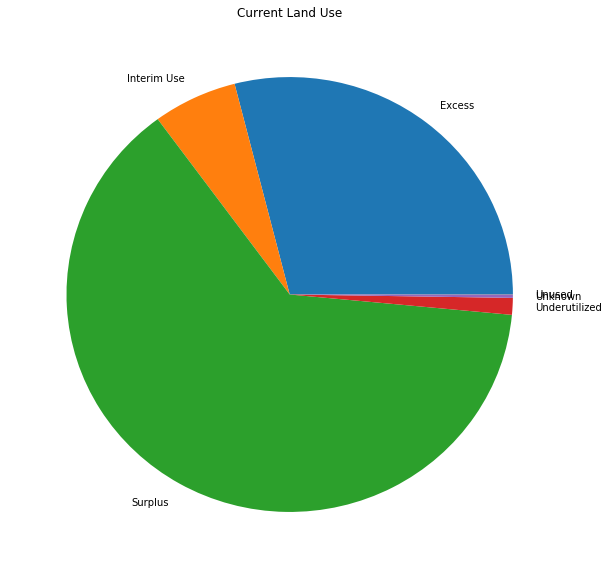

In [21]:
# Everything other than fully utilized land. 
series = pd.Series(distribution.drop(["Fully Utilized"], axis=0), name=' ')
series.plot.pie(figsize=(10, 10))
plt.title("Current Land Use")
plt.show()

In [22]:
# TODO: Figure out how many people can be housed in: 

# Land that is not fully utilized: 17826358 sq. ft

Details of PMA Classification of owned land.
https://www.seattle.gov/Documents/Departments/FAS/RealEstateServices/Property/2017-real-property-report.pdf

In [42]:
a = "Kyle is sexy"
print(a)

Kyle is sexy


In [25]:
# Permit type category key
# 1 = Single Family 5000
# 2 = Single Family 7200
# 3 = Lowrise 1
# 4 = Lowrise 2
# 5 = Lowrise 3
# 6 = Commercial2-65
# 7 = Neighborhood Commercial2-40
# 8 = Industrial General1
# 9 = Industrial Commercial-45
# 10 = Neighborhood Commercial1-30 
# 11 = Neighborhood Commercial3-30 
import math
inventory_with_permits = pd.read_csv("./datasets/property_inventory_2017_csv.csv")
# inventory_with_permits
#RANGE_OF_LOTS = 3:82 # Removing 3 abnormally large, commercially zoned plots
permit_select = inventory_with_permits.loc[:, ["PMA Location Address"," PMA Land SqFt ","PMA Classification","Permit Type"]]

# for i in list(inventory_with_permits):
#     print("#"+i+"#")
permit_frame = pd.DataFrame(permit_select)
# Creates a data frame where we filter out any 
has_permit_filter = (permit_frame["Permit Type"] == permit_frame["Permit Type"])
permit_frame = permit_frame[has_permit_filter]
#permit_frame

In [32]:
LR_STORY_MAX = 3
COMMERCIAL_STORY_MAX = 3

# Function responsible for taking in a row from the excess land
# dataframe 
def getBuildableSqft(row):
    sqftTotal = float(row[' PMA Land SqFt '].replace(",", ""))
    permitCategory = float(row["Permit Type"])
    # The following are business rules discerned from the Seattle
    # zoning information from their website http://www.seattle.gov/dpd/codesrules/codes/zoning/default.htm
    ## Lots zoned for SF but less than 5000 sqft get a maximum of
    ## 1000 sqft + 15% of lot area)
    if (permitCategory in [1.0, 2.0]) and sqftTotal < 5000:
        maxAreaForSmallerLot = 1000 + 0.15 * sqftTotal
        if maxAreaForSmallerLot > sqftTotal:
            # If the buildable area is less than a few thousand sqft,
            # it is doubtful it could be used to build affordable housing
            # that should be taken in to account on the data frame however
            
            # It is important to understand what is meant when the sqft is divded.
            # There is single family zoning, which restricts the size of house you can build.
            # So imagine you build the house, with very small rooms and shard amenities 
            # (much like living in the udistrict) then that is the kind of afordable
            # housing that is modeled when you are looking at single family zones.
            return sqftTotal
        else:
            return maxAreaForSmallerLot
    elif (permitCategory in [1.0, 2.0]) and sqftTotal > 5000:
        # for lots bigger than 5000sqft you can use 30% of the land
        return (0.35 * sqftTotal)
    elif (permitCategory in [3.0, 4.0, 5.0]):
        # If you are trying to understand the buildable area
        # for a lowrise, use
        return getLowriseSqft(sqftTotal, permitCategory)
    elif (permitCategory in [6.0, 7.0, 10.0, 11.0]):
        # Given permits are commercially zoned, special residential rule;s apply.
        return getCommercialSqft(sqftTotal, permitCategory)
    elif (permitCategory in [8.0, 9.0]):
        # Cannot build residential in industrial zones
        # so certain areas in Leary cannot be built on at this time.
        return 0
    
        
# Lowrise zoning has predefined density limits. Therefore, for lowrise 1, 2, 3 zones you
# must use this function which will return the number of units that could be built.
# this function takes in to account, the extra height you can build with.
def getLowriseSqft(sqftTotal, permitCategory):
    if permitCategory in [3.0, 4.0]:
        # Lowrise1 zoning
        # Assuming FAR Ratio of at least 1.0, which
        # is apparently the FAR measure for an apartment
        # Height limit is 3 stories (30ft + 5ft roof)
        totalBuildableSqft = (sqftTotal * 3) * 0.75
        return totalBuildableSqft
    elif permitCategory == 5.0:
        # Lowrise3 zoning
        # Height limit is 3 stories (30ft + 5ft roof) if
        # lot is outside of a growth area or within 50' of
        # a SF zone (so like, everywhere)
        totalBuildableSqft = (sqftTotal * LR_STORY_MAX) * 0.75
        return totalBuildableSqft
    else:
        # This is not a lowrise zoned building
        return 0

# commerical zoning estimation
def getCommercialSqft(sqftTotal, permitCategory):
    if (permitCategory in [6.0, 7.0, 10.0, 11.0]):
        # For commercial zones you can build residential dwellings 
        # above the first floor (which must contain some shops for example)
        # and the typical height limit varies but the median value for 
        # heights allowed is 65 ft, which I interpretted to mean 
        # 6 stories (so we multiply by 5 because the first floor is shops)
        # subtract 5% for area that leads to otudoors as per the zoning requirements.
        totalBuildableSqft = (sqftTotal * COMMERCIAL_STORY_MAX) - (sqftTotal * 0.05) 
        return totalBuildableSqft
    else:
        return 0

# Minimal Unit Size based on permit type
# Single Family 300sqft
# Lowrise 1 = 2000 sqft
# Lowrise 2 = 1200 sqft
# Lowrise 3 = 800 sqft
# Commercial (6, 7, 10, 11) = 150sqft Small Effiency Dwelling Units
# Henry's value is 300sqft, and a more middle value is 500sqft

In [33]:
def calculateBuildableTotal(row):
    sqftTotal = float(row[' PMA Land SqFt '].replace(",", ""))
    buildable = float(row["buildableSqft"])
    return buildable / sqftTotal


permit_frame['buildableSqft'] = permit_frame.apply(lambda row: getBuildableSqft(row), axis=1)
permit_frame['buildable/totalSqft'] = permit_frame.apply(lambda row: calculateBuildableTotal(row), axis=1)

In [40]:
def calculateUnits(row):
    sqftBuildable = float(row['buildableSqft'])
    permitCategory = float(row["Permit Type"])
    if permitCategory in [1.0, 2.0]:
        return sqftBuildable // 1800
    elif permitCategory in [3.0]:
        return sqftBuildable // 2000
    elif permitCategory in [4.0]:
        return sqftBuildable // 1200
    elif permitCategory in [5.0]:
        return sqftBuildable // 800
    elif permitCategory in [6.0, 7.0, 10.0, 11.0]:
        return sqftBuildable // 800
    else:
        return 0

def calculateUnitsAllLowrise(row):
    sqftBuildable = float(row['buildableSqft'])
    permitCategory = float(row["Permit Type"])
    if permitCategory in [6.0, 7.0, 10.0, 11.0]:
        return ((sqftBuildable / 5) * 3) // 2000
    else:
        return sqftBuildable // 2000
    
    
def calculateCost(row):
    sqftBuildable = float(row['buildableSqft'])
    permitCategory = float(row["Permit Type"])
    if permitCategory in [1.0, 2.0]:
        return sqftBuildable * 150
    elif permitCategory in [3.0, 4.0, 5.0, 6.0, 7.0, 10.0, 11.0]:
        return sqftBuildable * 170
    else:
        return 0

def calculateCostAllLowrise(row):
    sqftBuildable = float(row['buildableSqft'])
    return sqftBuildable * 170

    
permit_frame['units_estimate'] = permit_frame.apply(lambda row: calculateUnits(row), axis=1)
permit_frame['cost_estimate'] = permit_frame.apply(lambda row: calculateCost(row), axis=1)
permit_frame['all_lowrise_unit_estimate'] = permit_frame.apply(lambda row: calculateUnitsAllLowrise(row), axis=1)
permit_frame['all_lowrise_cost_estimate'] = permit_frame.apply(lambda row: calculateCostAllLowrise(row), axis=1)

In [41]:
# 
permit_frame

,PMA Location Address,PMA Land SqFt,PMA Classification,Permit Type,buildableSqft,buildable/totalSqft,units_estimate,cost_estimate,all_lowrise_unit_estimate,all_lowrise_cost_estimate
0,9501 Myers Way S,"711,204",Excess,6.0,2098051.80,2.950000,2622.0,356668806.0,629.0,356668806.0
1,9701 Myers Way S,"453,228",Excess,6.0,1337022.60,2.950000,1671.0,227293842.0,401.0,227293842.0
2,9600 Myers Way S,"296,507",Excess,6.0,874695.65,2.950000,1093.0,148698260.5,262.0,148698260.5
3,8237 44th Ave SW,"55,010",Excess,1.0,19253.50,0.350000,10.0,2888025.0,9.0,3273095.0
4,3401 S Della St,"34,760",Excess,1.0,12166.00,0.350000,6.0,1824900.0,6.0,2068220.0
5,525 N 85th St,"22,056",Excess,7.0,65065.20,2.950000,81.0,11061084.0,19.0,11061084.0
6,7328 16th Ave SW,"21,977",Excess,2.0,7691.95,0.350000,4.0,1153792.5,3.0,1307631.5
7,2765 Harbor Ave SW,"20,112",Excess,2.0,7039.20,0.350000,3.0,1055880.0,3.0,1196664.0
8,101 23rd Ave S,"19,604",Excess,5.0,44109.00,2.250000,55.0,7498530.0,22.0,7498530.0
9,7018 Lincoln Park Way SW,"18,197",Excess,1.0,6368.95,0.350000,3.0,955342.5,3.0,1082721.5


In [42]:
print("Units that can be built " + str(permit_frame["units_estimate"].sum()))
print("Cost of units " + str(permit_frame["cost_estimate"].sum()))
print("Cost per unit $" + str(permit_frame["cost_estimate"].sum()/permit_frame["units_estimate"].sum()))
print("LR - Units that can be built " + str(permit_frame["all_lowrise_unit_estimate"].sum()))
print("LR - Cost of units " + str(permit_frame["all_lowrise_cost_estimate"].sum()))
print("LR - Cost per unit $" + str(permit_frame["all_lowrise_cost_estimate"].sum()/permit_frame["all_lowrise_unit_estimate"].sum()))

Units that can be built 7318.0
Cost of units 1068912064.5
Cost per unit $146066.1471030336
LR - Units that can be built 2143.0
LR - Cost of units 1073686654.5
LR - Cost per unit $501020.3707419505
